In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

In [2]:
train = pd.read_feather("../input/food-quality-baseline/train.fr")
test = pd.read_feather("../input/food-quality-baseline/test.fr")
sample_sub = pd.read_feather('../input/food-quality-baseline/sample_sub.fr')
ID_COL, TARGET_COL = 'ID', 'Inspection_Results'
df = pd.concat([train, test]).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [3]:
def get_date_features(df):
    df['Date'] = pd.to_datetime(df["Date"], format = "%d-%m-%Y", errors='coerce')
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
get_date_features(df)

In [4]:
for c in ['FacilityID', 'FacilityName', 'LicenseNo', 'Geo_Loc']:
    temp = df.sort_values(by='Date').groupby(c)['Date'].diff(1).sort_index()
    df[f'next_Inspection_day_diff_{c}'] = temp.dt.days

In [5]:
df[['prev_Reason', 'prev_SectionViolations']] = df.sort_values(by='Date').groupby('FacilityID')[['Reason', 'SectionViolations']].shift(1).sort_index()

In [6]:
for i in range(1, 6):
    df[[f'next{i}_Reason_LicenseNo', f'next{i}_SectionViolations_LicenseNo', f'next{i}_RiskLevel_LicenseNo']] = df.sort_values(by='Date').groupby('LicenseNo')[['Reason', 'SectionViolations', 'RiskLevel']].shift(-i).sort_index()
    
for i in range(1, 6):
    df[[f'next{i}_Reason_geoloc', f'next{i}_SectionViolations_geoloc', f'next{i}_RiskLevel_geoloc']] = df.sort_values(by='Date').groupby('Geo_Loc')[['Reason', 'SectionViolations', 'RiskLevel']].shift(-i).sort_index()
    
for i in range(1, 6):
    df[[f'next{i}_Reason_id', f'next{i}_SectionViolations_id', f'next{i}_RiskLevel_id']] = df.sort_values(by='Date').groupby('FacilityID')[['Reason', 'SectionViolations', 'RiskLevel']].shift(-i).sort_index()
    
for i in range(1, 6):
    df[[f'next{i}_Reason_name', f'next{i}_SectionViolations_name', f'next{i}_RiskLevel_name']] = df.sort_values(by='Date').groupby('FacilityName')[['Reason', 'SectionViolations', 'RiskLevel']].shift(-i).sort_index()

In [7]:
df['SectionViolations_cumsum'] = df.sort_values(by='Date').groupby('FacilityID')['SectionViolations'].cumsum().shift(-1).sort_index()

In [8]:
grp = df.groupby('year').agg({'SectionViolations': ['max', 'sum', 'mean', 'min'], 'FacilityID': ['nunique' ,'size'], 'Geo_Loc': ['nunique','size'],
                              'FacilityName': ['nunique','size'], 'LocationID': ['nunique','size'], 'LicenseNo': ['nunique','size'] ,'Type': ['nunique' ,'size']})
grp.columns = ['_'.join(c).strip('_') + '_yearwise' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on ='year')

In [9]:
grp = df.groupby(['FacilityID', 'Date']).agg({'SectionViolations': ['max', 'sum', 'mean', 'min'], 'Geo_Loc': ['nunique','size'],'Reason': ['nunique', 'size'],
                                     'FacilityName': ['nunique','size'], 'LocationID': ['nunique','size'], 'LicenseNo': ['nunique','size'] ,'Type': ['nunique' ,'size']})
grp.columns = ['_'.join(c).strip('_') + '_FacilityID_and_Date_based' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['FacilityID', 'Date'])

In [10]:
grp = df.groupby(['FacilityName', 'Date']).agg({'SectionViolations': ['max', 'sum', 'mean', 'min'], 'Geo_Loc': ['nunique','size'],'Reason': ['nunique', 'size'],
                                     'FacilityID': ['nunique','size'], 'LocationID': ['nunique','size'], 'LicenseNo': ['nunique','size'] ,'Type': ['nunique' ,'size']})
grp.columns = ['_'.join(c).strip('_') + '_FacilityName_and_Date_based' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['FacilityName', 'Date'])

In [11]:
grp = df.groupby(['LicenseNo', 'Date']).agg({'SectionViolations': ['max', 'sum', 'mean', 'min'], 'Geo_Loc': ['nunique','size'],'Reason': ['nunique', 'size'],
                                     'FacilityID': ['nunique','size'], 'LocationID': ['nunique','size'], 'LicenseNo': ['nunique','size'] ,'Type': ['nunique' ,'size']})
grp.columns = ['_'.join(c).strip('_') + '_LicenseNo_and_Date_based' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on =['LicenseNo', 'Date'])

In [12]:
grp = df.groupby('LicenseNo').agg({'SectionViolations': ['mean'], 'FacilityID': ['nunique'],
                              'FacilityName': ['nunique'], 'LocationID': ['nunique'], 'Geo_Loc': ['nunique']})
grp.columns = ['_'.join(c).strip('_') + '_Geo_Loc_based' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on ='LicenseNo')

In [13]:
grp = df.groupby('FacilityID').agg({'SectionViolations': ['max'], 'Geo_Loc': ['nunique'],
                              'FacilityName': ['nunique'], 'LocationID': ['nunique'], 'LicenseNo': ['nunique']})
grp.columns = ['_'.join(c).strip('_') + '_FacilityID_based' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on ='FacilityID')

In [14]:
grp = df.groupby('Reason').agg({'SectionViolations': ['max'], 'FacilityID': ['nunique'], 'Geo_Loc': ['nunique'],
                              'FacilityName': ['nunique'], 'LocationID': ['nunique'], 'LicenseNo': ['nunique']})
grp.columns = ['_'.join(c).strip('_') + '_Reason_based' for c in grp.columns]
df = pd.merge(df, grp, how = 'left', on ='Reason')

In [15]:
df[f'n_days_from_start'] = (df['Date'].dt.date - df['Date'].min().date()).dt.days
df[f'n_weeks_from_start'] = (df['Date'].dt.date - df['Date'].min().date()).dt.days//7
df[f'n_days_from_end'] = (df['Date'].max().date() - df['Date'].dt.date).dt.days
df[f'n_weeks_from_end'] = (df['Date'].max().date() - df['Date'].dt.date).dt.days//7

In [16]:
for c in tqdm_notebook(['FacilityID', 'FacilityName', 'LicenseNo']):
    df[f'next_inspection_day_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(-1))
    df[f'prev_inspection_day_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(1))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [17]:
for c in tqdm_notebook(['FacilityID', 'FacilityName', 'LicenseNo']):
    df[f'next2_inspection_day_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(-2))
    df[f'prev2_inspection_day_diff_{c}'] = df.sort_values(by='Date').groupby(c)['n_days_from_start'].apply(lambda x: x - x.shift(2))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [18]:
df[f'n_days_from_start_fid'] = df.groupby('FacilityID')['Date'].apply(lambda x: (x - x.min()).dt.days)
df[f'n_days_from_end_fid'] = df.groupby('FacilityID')['Date'].apply(lambda x: (x.max() - x).dt.days)
df[f'n_days_from_end_lno'] = df.groupby('LicenseNo')['Date'].apply(lambda x: (x.max() - x).dt.days)
df[f'n_days_from_start_lno'] = df.groupby('LicenseNo')['Date'].apply(lambda x: (x-x.min()).dt.days)

In [19]:
df[f'n_days_from_start_fn'] = df.groupby('FacilityName')['Date'].apply(lambda x: (x - x.min()).dt.days)
df[f'n_days_from_end_fn'] = df.groupby('FacilityName')['Date'].apply(lambda x: (x.max() - x).dt.days)
df[f'n_days_from_start_geoloc'] = df.groupby('Geo_Loc')['Date'].apply(lambda x: (x - x.min()).dt.days)
df[f'n_days_from_end_geoloc'] = df.groupby('Geo_Loc')['Date'].apply(lambda x: (x.max() - x).dt.days)

In [20]:
high_cardinality_cols = ['FacilityID', 'FacilityName', 'Geo_Loc', 'LicenseNo', 'Street', 'Type', 'LocationID']
for c in tqdm_notebook(high_cardinality_cols):
    temp = pd.Series(pd.factorize(df['Date'].astype('str') + df[c].astype('str'))[0])
    temp =  temp.map(temp.value_counts())
    df[f'Date_{c}_freq'] = temp

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [21]:
cat_cols = ['City', 'Date', 'FacilityID', 'FacilityName', 'Geo_Loc', 'LicenseNo', 'LocationID', 'Reason', 'RiskLevel', 'State', 'Street', 'Type']
obj_cols = df.select_dtypes('object').columns.tolist()
cat_cols = list(set(cat_cols + obj_cols))
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

In [22]:
df[[c + '_freq' for c in cat_cols]] = df[cat_cols].apply(lambda x: x.map(x.value_counts()))

In [23]:
train, test = df.iloc[:train.shape[0]], df.iloc[train.shape[0]:]
test.reset_index(drop=True, inplace=True)
target = train[TARGET_COL]
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [24]:
print(len(features))

247


In [25]:
X_trn, X_val, y_trn, y_val = train_test_split(train[features], target, test_size=0.1, stratify=target, random_state=10)
X_test = test[features]

In [26]:
clf = LGBMClassifier(learning_rate=0.01, colsample_bytree=0.3, reg_alpha=3, reg_lambda=3, max_depth=-1, n_estimators=2000, min_child_samples=15, num_leaves=141)
_ = clf.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=100, early_stopping_rounds=100)
predictions_val_lgb = clf.predict_proba(X_val)
print(f"Log loss for Model 1 is: {log_loss(y_val, predictions_val_lgb)}")

Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.461479	valid_1's multi_logloss: 0.470385
[200]	training's multi_logloss: 0.243531	valid_1's multi_logloss: 0.257929
[300]	training's multi_logloss: 0.160794	valid_1's multi_logloss: 0.180883
[400]	training's multi_logloss: 0.123716	valid_1's multi_logloss: 0.150214
[500]	training's multi_logloss: 0.10338	valid_1's multi_logloss: 0.136754
[600]	training's multi_logloss: 0.0902135	valid_1's multi_logloss: 0.130428
[700]	training's multi_logloss: 0.0803522	valid_1's multi_logloss: 0.127098
[800]	training's multi_logloss: 0.0723461	valid_1's multi_logloss: 0.125268
[900]	training's multi_logloss: 0.0655947	valid_1's multi_logloss: 0.12413
[1000]	training's multi_logloss: 0.0597837	valid_1's multi_logloss: 0.123348
[1100]	training's multi_logloss: 0.0547034	valid_1's multi_logloss: 0.122874
[1200]	training's multi_logloss: 0.0502738	valid_1's multi_logloss: 0.122569
[1300]	training's multi_loglos

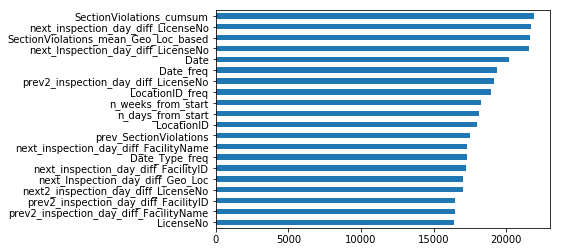

In [27]:
fi = pd.Series(index=features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[:20][::-1].plot.barh()

In [28]:
predictions_test_lgb = clf.predict_proba(X_test)

In [29]:
target_mapper = {0:'FACILITY CHANGED',
1:'FAIL',
2:'FURTHER INSPECTION REQUIRED',
3:'INSPECTION OVERRULED',
4:'PASS',
5:'PASS(CONDITIONAL)',
6:'SHUT-DOWN'}
sub_df = pd.DataFrame(predictions_test_lgb)
sub_df.columns = [target_mapper[c] for c in sub_df.columns]
sub_df.to_excel("food_quality_final_solution.xlsx", index=False)